# Tensorflow & Keras によるニューラルネットワーク（NN）入門

In [4]:
# いつものモジュールをインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Irisデータ用
from sklearn import datasets

# Tensorflow & Keras
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam

# まずは基本的な要素から

In [5]:
# ネットワークで使用する各種変数はTensorflowのVariableオブジェクト
x1 = tf.Variable(1.0)
x2 = tf.Variable(2.0)
x3 = tf.Variable(3.0)

In [8]:
# 値の確認
x1.value()

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [4]:
# 試しに計算をしてみる（順向き）
# GradientTape を with で実行している間，変数はウォッチ（watch）される
with tf.GradientTape() as g:
    z = (x1 - 2 * x2 - 1) ** 2 + (x2 * x3 - 1) ** 2 + 1

In [5]:
# この結果をもとに，今度は勾配（微分値＝逆向き）計算
dz = g.gradient(z, (x1, x2, x3))

# x1, x2, x3に関する微分値は
print(dz)

(<tf.Tensor: shape=(), dtype=float32, numpy=-8.0>, <tf.Tensor: shape=(), dtype=float32, numpy=46.0>, <tf.Tensor: shape=(), dtype=float32, numpy=20.0>)


In [6]:
# Variableを変数とする関数群がある
# たとえば
x4 =tf.Variable(-1.0)
print(tf.sin(x4))
print(tf.sigmoid(x4))

tf.Tensor(-0.84147096, shape=(), dtype=float32)
tf.Tensor(0.26894143, shape=(), dtype=float32)


In [7]:
# もちろん微分できる
x5 = tf.Variable(np.array([0.5], dtype=np.float32))

with tf.GradientTape() as g:
    z5 = tf.cos(x5)

print(z5)
dz5 = g.gradient(z5, x5)

# 微分値
print(dz5)

# cos(x)の導関数は-sin(x)
print((-1) * tf.sin(x5))

tf.Tensor([0.87758255], shape=(1,), dtype=float32)
tf.Tensor([-0.47942555], shape=(1,), dtype=float32)
tf.Tensor([-0.47942555], shape=(1,), dtype=float32)


# Kerasでネットワークを構成してみる

Tensorflowでこれらを使用していけばネットワークを構成できるが，Kerasを使用すれば基本的なネットワークは容易に作成することができる

In [8]:
# たとえば入力4つ，第1層の出力3つ，第2層の出力3つのネットワーク

# Sequentialでfeed-forwardのネットワークを準備する
model = Sequential()

# 各層を順次追加していく，まずは第1層
# Denseとは通常の（線形の）層のこと
model.add(Dense(input_dim=4, units=3))
# 活性化関数はシグモイド
model.add(Activation('sigmoid'))

# 第2層
model.add(Dense(units=3))
model.add(Activation('sigmoid'))

学習の際は，損失関数の種類と学習（最適化）の方法をセットする

In [9]:
# 損失関数は平均二乗誤差（MSE）で，確率的最急勾配法（SGD）をセット
model.compile(loss='mse', optimizer=SGD(learning_rate=0.1))

あとは気が済むまで学習<br/>
1つのデータセット（バッチ）ごとに，パラメータを1回更新するのが基本

In [10]:
# ランダムなデータで学習，1バッチあたり2つのサンプルとする
x = np.random.rand(8).astype(np.float32).reshape(2,4)
y = np.random.rand(6).astype(np.float32).reshape(2,3)

# 10回（10エポック）学習する
model.fit(x, y, epochs=10)

Epoch 1/10
1/1 [==============================] - 1s 582ms/step - loss: 0.0681
Epoch 2/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0678
Epoch 3/10
1/1 [==============================] - 0s 0s/step - loss: 0.0676
Epoch 4/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0674
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0672
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0670
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0668
Epoch 8/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0666
Epoch 9/10
1/1 [==============================] - 0s 0s/step - loss: 0.0664
Epoch 10/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0662


これら3ステップが，Kerasにおけるネットワークの学習の基本

# IrisでNNを試してみる

Irisは入力が4次元，正解ラベルは3種類（3分類），計150個のデータである

In [11]:
# データをscikit-learnから読み込む
iris = datasets.load_iris()

# 学習データのベクトル
X = iris.data

# 正解データの準備（one-hotベクトルにする）
Y = tensorflow.keras.utils.to_categorical(iris.target)

# データを学習用とテスト用の2つに分ける（75個ずつ）
# XとYを一つおきに振り分けて作成
index = np.arange(len(X))
xtrain = X[index[index % 2 != 0]]
ytrain = Y[index[index % 2 != 0]]
xtest = X[index[index % 2 == 0]]
ytest = Y[index[index % 2 == 0]]

In [12]:
# 学習データの順番をランダムにする
import random
n = len(xtrain)
rnd = random.sample(list(range(n)), n)
xtrain = xtrain[rnd]
ytrain = ytrain[rnd]

## 基本的なネットワーク

まず，中間層6ノードのNNを作る

In [13]:
# このように作成することもできる
iris_model = Sequential([
    # "units=" は省略できる
    Dense(6, input_dim=4),
    Activation('sigmoid'),
    # このように活性化関数もまとめて書くことができる
    Dense(3, activation='softmax'),
])

# モデルのあらましとパラメータ（の初期値）を見てみる
iris_model.summary()
iris_model.weights

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6)                 30        
                                                                 
 activation_2 (Activation)   (None, 6)                 0         
                                                                 
 dense_3 (Dense)             (None, 3)                 21        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


[<tf.Variable 'dense_2/kernel:0' shape=(4, 6) dtype=float32, numpy=
 array([[-0.69613636, -0.14387268,  0.65234303, -0.38553873, -0.468173  ,
          0.1181913 ],
        [ 0.34312475, -0.20246255, -0.7412026 , -0.3498807 ,  0.10624856,
          0.01928264],
        [-0.524817  , -0.02740347,  0.17778754, -0.6024827 ,  0.4625095 ,
          0.19786465],
        [-0.3595582 , -0.43446204, -0.16232276,  0.713994  ,  0.22177881,
          0.686015  ]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(6,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_3/kernel:0' shape=(6, 3) dtype=float32, numpy=
 array([[ 0.6630603 , -0.6811296 ,  0.41639423],
        [ 0.59113693, -0.09416014, -0.7101462 ],
        [ 0.29195487,  0.3376199 , -0.7370345 ],
        [ 0.6027204 , -0.52990603, -0.1137951 ],
        [-0.39734164, -0.09870815,  0.70641637],
        [-0.76615506,  0.6517279 , -0.10471129]], dtype=float32)>,
 <tf.Variable 'dense_3/bias:0' sha

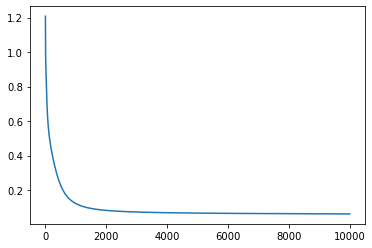

In [14]:
# Irisは3クラスの分類なので，クロスエントロピー基準で学習
iris_model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.1), metrics=['accuracy'])

# 学習を10000回反復することにする
# 進捗状況（プログレスバー）を非表示にする場合はverboseを0にする
h = iris_model.fit(xtrain, ytrain, epochs=10000, batch_size=75, verbose=0)

# fitは学習の経過を返すので，損失の値についてプロットして確認
plt.plot(h.history['loss'])

テストデータで性能を測る<br/>
（NNの学習にはランダム性が入るので，同じデータから常に<br/>
同じモデルが得られるわけではなく，性能も変化することに注意）

In [15]:
# 正解率
iris_model.evaluate(xtest, ytest)

# 予測自体はpredictでできる
p = iris_model.predict(xtest)

# 確率が最大のものが予測結果のラベル
np.argmax(p, axis=-1)

3/3 [==============================] - 0s 2ms/step - loss: 0.0563 - accuracy: 0.9733


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

## ミニバッチ

学習データのサブセットを用意して学習する手法

3/3 [==============================] - 0s 0s/step - loss: 0.0525 - accuracy: 0.9733 


[0.052488893270492554, 0.9733333587646484]

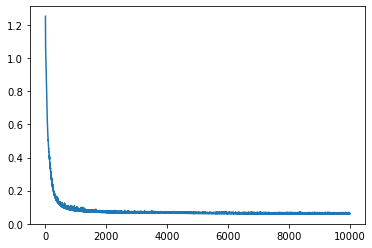

In [16]:
iris_model2 = Sequential([
    Dense(6, input_dim=4, activation='sigmoid'),
    Dense(3, activation='softmax'),
])
iris_model2.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.1), metrics=['accuracy'])

# サンプル25個ごとに勾配計算
h = iris_model2.fit(xtrain, ytrain, epochs=10000, batch_size=25, verbose=0)

# 損失をプロットして確認
plt.plot(h.history['loss'])

# 正解率
iris_model2.evaluate(xtest, ytest)

# L2正則化

重みに制約をかけて過学習を抑制する

3/3 [==============================] - 0s 8ms/step - loss: 0.0674 - accuracy: 0.9733


[0.06737741827964783, 0.9733333587646484]

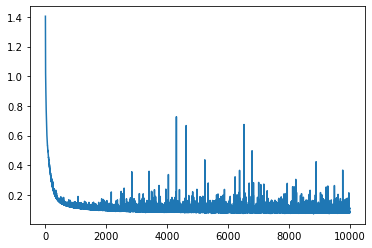

In [17]:
# モデルの設計時に正則化を組み込む
iris_model3 = Sequential([
    Dense(6, input_dim=4, activation='sigmoid', kernel_regularizer=tensorflow.keras.regularizers.l2(0.001)),
    Dense(3, activation='softmax'),
])

# 学習
iris_model3.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.1), metrics=['accuracy'])
h = iris_model3.fit(xtrain, ytrain, epochs=10000, batch_size=25, verbose=0)
plt.plot(h.history['loss'])

# 正解率
iris_model3.evaluate(xtest, ytest)

# ドロップアウト

ネットワーク内のユニットをランダムに落として学習することで過学習を抑制する

3/3 [==============================] - 0s 0s/step - loss: 0.1342 - accuracy: 0.9600


[0.13424326479434967, 0.9599999785423279]

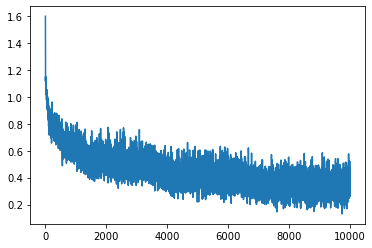

In [18]:
# モデルの設計時に正則化を組み込む
iris_model4 = Sequential([
    Dense(6, input_dim=4, activation='sigmoid'),
    # ↑この層からドロップさせる割合を指定
    Dropout(0.5),
    Dense(3, activation='softmax'),
])

# 学習
iris_model4.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.1), metrics=['accuracy'])
h = iris_model4.fit(xtrain, ytrain, epochs=10000, batch_size=25, verbose=0)
plt.plot(h.history['loss'])

# 正解率
iris_model4.evaluate(xtest, ytest)

# 学習の進行と損失関数

最初のIrisのNNについて，損失関数と性能の変化をみてみる

3/3 [==============================] - 0s 0s/step - loss: 0.0772 - accuracy: 0.9867


[0.07723819464445114, 0.9866666793823242]

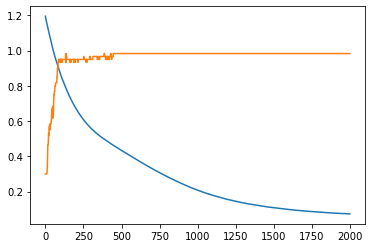

In [20]:
iris_model5 = Sequential([
    Dense(6, input_dim=4, activation='sigmoid'),
    Dense(3, activation='softmax'),
])
# 最適化をAdamにしてみる
iris_model5.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# 学習は2000回にする
# 学習データの一部を分けて検証に使う
h = iris_model5.fit(xtrain, ytrain, epochs=2000, batch_size=25, verbose=0, validation_split=0.2)

plt.plot(h.history['loss'])
plt.plot(h.history['accuracy'])
iris_model5.evaluate(xtest, ytest)

なお，学習の際にTracingの警告（warning）が出ることがありますが，ここでは問題ありません